In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append("/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/hl2ss/viewer")
import cv2

%matplotlib inline

In [2]:
from mpl_toolkits import mplot3d
import json
import hl2ss
import hl2ss_3dcv

In [3]:
from PoseVisualizer import CameraPoseVisualizer
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Turning Mesh into Depth Image

In [4]:
PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/an_place/raw-04-09-08-07/'
PATH_MESH = PATH + 'mesh/'

In [5]:
CALIB_PATH = '/home/andang/workspace/Computational_Vision/HL2/Hololens-Project/datasets/test/'
def get_all_calibration():
    calib_pv = hl2ss_3dcv._load_calibration_pv(CALIB_PATH+'calibrations/personal_video')
    calib_lt = hl2ss_3dcv._load_calibration_rm_depth_longthrow(CALIB_PATH+'calibrations/rm_depth_longthrow')
    calib_ahat = hl2ss_3dcv._load_calibration_rm_depth_ahat(CALIB_PATH+'calibrations/rm_depth_ahat')
    calib_rf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightfront')
    calib_lf = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftfront')
    calib_rr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_rightright')
    calib_lr = hl2ss_3dcv._load_calibration_rm_vlc(CALIB_PATH+'calibrations/rm_vlc_leftleft')
    
    uv2xy = hl2ss_3dcv.compute_uv2xy(calib_ahat.intrinsics, hl2ss.Parameters_RM_DEPTH_AHAT.WIDTH, hl2ss.Parameters_RM_DEPTH_AHAT.HEIGHT)
    xy1, scale = hl2ss_3dcv.rm_depth_compute_rays(uv2xy, calib_ahat.scale)
    
    #return all calibrations + xy1 + scale
    return calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy1, scale

In [6]:
calib_pv, calib_ahat, calib_lt, calib_lf, calib_rf, calib_lr, calib_rr, xy, scale = get_all_calibration()

In [7]:
mesh_hmap = {}

for path in os.listdir(PATH_MESH):
    split_names = (path.split('.txt')[0]).split('_')
    info_type = split_names[1]
    timestamp = split_names[2]
    data = np.loadtxt(PATH_MESH+path) #load up info
    
    if not (timestamp in mesh_hmap):
        mesh_hmap[timestamp] = {}
    mesh_hmap[timestamp][info_type] = data


KeyboardInterrupt



In [8]:
#open3d rendering
open3d_meshes = []

for i,j in mesh_hmap.items():
    
    vertex_positions = j['vertex']
    triangle_indices = j['triangles']
    pose = j['pose']
    vertex_position_scale = j['vertexscale']
    vertex_normals = j['normals']
    
    vertex_positions[:, 0:3] = vertex_positions[:, 0:3] * vertex_position_scale
    vertex_positions = vertex_positions @ pose
    vertex_normals = vertex_normals @ pose
    
    open3d_mesh = o3d.geometry.TriangleMesh()
    open3d_mesh.vertices = o3d.utility.Vector3dVector(vertex_positions[:,0:3])
    open3d_mesh.vertex_colors = o3d.utility.Vector3dVector(vertex_normals[:, 0:3])
    open3d_mesh.triangles = o3d.utility.Vector3iVector(triangle_indices)
    open3d_meshes.append(open3d_mesh)

In [8]:
intrinsic = calib_ahat.intrinsics.T[:3,:3]
print(intrinsic)

default_extrinsic = np.eye(4)
default_extrinsic[3,3] = 0

[[114.55879   0.      256.11627]
 [  0.      114.85222 260.75302]
 [  0.        0.        1.     ]]


### Using Open3D to get what I want

In [16]:
set_bb = True
visualizer = o3d.visualization.Visualizer()
visualizer.create_window(width=512, height = 512)

#meshes 
for open3d_mesh in open3d_meshes:
    visualizer.add_geometry(open3d_mesh,set_bb)
    set_bb = False
    

ctr = visualizer.get_view_control()

#plugin params
# parameters = o3d.io.read_pinhole_camera_parameters(cam_intrinsic)
parameters = o3d.camera.PinholeCameraParameters()

parameters.intrinsic = o3d.camera.PinholeCameraIntrinsic(width = 512, height = 512, intrinsic_matrix=intrinsic)
parameters.intrinsic.set_intrinsics(512, 512, intrinsic[0,0],intrinsic[1,1],512/2 - 0.5, 512/2 - 0.5)
# parameters.extrinsic = calib_ahat.extrinsics.T
parameters.extrinsic = default_extrinsic

ctr.convert_from_pinhole_camera_parameters(parameters)


#run vis and get data
visualizer.run()
depth = visualizer.capture_depth_float_buffer()
image = visualizer.capture_screen_float_buffer()
visualizer.destroy_window()

In [17]:
np.asarray(image).shape

(512, 512, 3)

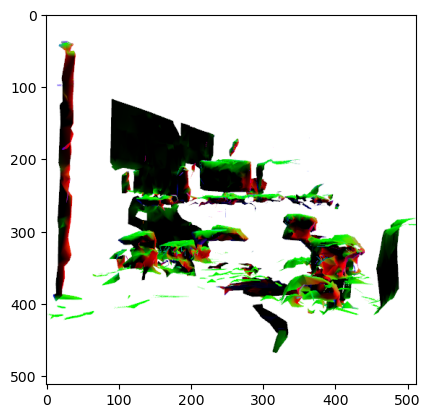

In [18]:
plt.imshow(np.asarray(image))

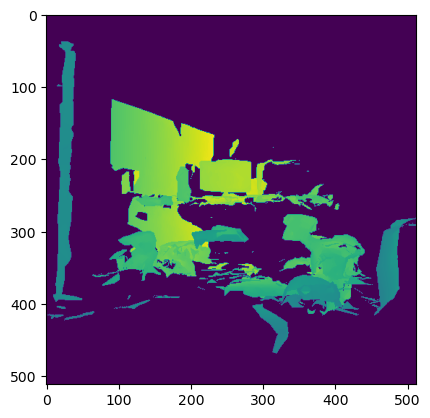

In [19]:
plt.imshow(np.asarray(depth))

### Moving over to .obj file

In [9]:
actor = o3d.io.read_triangle_mesh('test_scene.obj')

In [35]:
visualizer = o3d.visualization.Visualizer()
visualizer.create_window(width=int(intrinsic[0,2]*2), height = int(intrinsic[1,2]*2))

visualizer.add_geometry(actor,True)

ctr = visualizer.get_view_control()

#plugin params
# parameters = o3d.io.read_pinhole_camera_parameters(cam_intrinsic)
parameters = o3d.camera.PinholeCameraParameters()

parameters.intrinsic = o3d.camera.PinholeCameraIntrinsic(width = int(intrinsic[0,2]*2), height = int(intrinsic[1,2]*2), intrinsic_matrix=intrinsic)
parameters.intrinsic.set_intrinsics(512, 512, intrinsic[0,0],intrinsic[1,1],512/2 - 0.5, 512/2 - 0.5)
# parameters.extrinsic = calib_ahat.extrinsics.T
parameters.extrinsic = default_extrinsic

ctr.convert_from_pinhole_camera_parameters(parameters)

#run vis and get data
visualizer.run()
depth = visualizer.capture_depth_float_buffer()
image = visualizer.capture_screen_float_buffer()
visualizer.destroy_window()

[Open3D WARNING] [ViewControl] ConvertFromPinholeCameraParameters() failed because window height and width do not match.


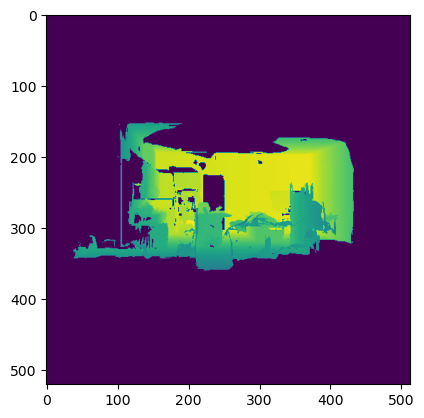

In [36]:
plt.imshow(np.asarray(depth))

In [37]:
import math
import os
import camera
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import open3d
import cv2 as cv
# import loader.loader as load

smplpath="test_scene.obj"

filepath,fullflname = os.path.split(smplpath)
fname,ext = os.path.splitext(fullflname)
outpath=os.path.dirname(filepath)+'/depth/'+fname+'.png'

def dict_to_open3dmesh(dict):
    mesh=open3d.TriangleMesh()
    mesh.vertices=open3d.open3d.Vector3dVector(dict['vertices'])
    mesh.vertex_colors=open3d.open3d.Vector3dVector(dict['rgbs'])
    mesh.triangles=open3d.open3d.Vector3iVector(dict['faces'])
    return mesh

def custom_draw_geometry_with_key_callback(pcd):
    w=512
    h=512
    f=114

    def capture_depth(vis):
        depth = vis.capture_depth_float_buffer()
        #open3d.write_image('depth.png',depth)
        cv.imwrite(outpath,(np.asarray(depth)*1000).astype(np.uint16))
        #plt.imshow(np.asarray(depth))
        #plt.savefig('depth.png')
        #plt.show()
        return False

    def apply_camera(vis):
        intrinsic=open3d.PinholeCameraIntrinsic()
        intrinsic.set_intrinsics(w,h, f, f, w/2.0-0.5, h/2.0-0.5)
        # extrinsic=np.array([
        # [    0.9981 ,-0.0160041,  0.0593907 ,   5.0298],
        # [0.0123974 ,  0.998087 , 0.0605806  , 5.59618],
        # [-0.060248, -0.0597236 ,  0.996391  ,  200.32826],
        # [       0.  ,        0. ,       0.     ,     1.]
        # ],dtype='float64')
        extrinsic=np.identity(4,dtype=np.float64)
        extrinsic[3,:] = np.array([0,0,10000])
        
        #from IPython import embed;embed()
        #extrinsic=np.identity(4, dtype='float64')
        vis.get_view_control().convert_from_pinhole_camera_parameters(intrinsic, extrinsic)  

    key_to_callback = {}
    key_to_callback[ord(",")] = capture_depth
    #key_to_callback[ord(".")] = capture_image
    key_to_callback[ord("A")] = apply_camera


    open3d.visualization.draw_geometries_with_key_callbacks([pcd], key_to_callback,width=w,height=h,left=0,top=0)

# m = load.Obj(smplpath)
# m=m.data
# mesh=dict_to_open3dmesh(m)
mesh = o3d.io.read_triangle_mesh('test_scene.obj')
mesh.compute_vertex_normals()
custom_draw_geometry_with_key_callback(mesh)

TriangleMesh with 40543 points and 72235 triangles.